## For a given lake, grab all MERRA2 fields for the bounding box +/- 5 degrees 

To help us composite gridded quantities by distance from the CWV=55mm boundary contour, with a `groupby().mean()` operation, we need to construct a new distance field on the MERRA2 grid.

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import geopandas as gp

## Read all lakes in 2014-2018 
#### lakes dataframe was "improved" in LakeCaseStudy.ipynb with firsttime added

In [2]:
df = pd.read_csv('ccvls_stats_2014-2018.improved.csv')
# df

In [215]:
equatorcases = df[ abs(df.coastlat) < 10 ] # 162 of them exceeding 1 day 
eq7cases = equatorcases[ equatorcases.dur_days > 6 ]  # 39 of them exceeding a week (more than 6 in days) 
eq7cases.maxarea.size

39

In [216]:
# Pick one
case = eq7cases.iloc[5]

In [4]:
filename = case.filename
gdf = gp.read_file('GEOJSONS/'+filename)
gdf.set_crs(epsg = "4326", inplace = True)

# to avoid area warnings, use an equal-area map projection (CRS) - oh it doesnt matter near the equator on coarse grids
# https://gis.stackexchange.com/questions/372564/userwarning-when-trying-to-get-centroid-from-a-polygon-geopandas
#.to_crs('+proj=cea')

,tqv_values,area,maxlon,time,tag,geometry
0,55,3.127315430115578,41.3606914397209,2017-05-28T11:00:00,2017_05_28_11_lat5p291S,"POLYGON ((39.37500 -6.01948, 40.00000 -6.05890..."
1,55,3.705780883103892,41.50255306746608,2017-05-28T10:00:00,2017_05_28_11_lat5p291S,"POLYGON ((39.37500 -6.20799, 40.00000 -6.10609..."
2,55,4.421360536963331,41.61843544195506,2017-05-28T09:00:00,2017_05_28_11_lat5p291S,"POLYGON ((41.25000 -6.51209, 41.30522 -6.50000..."
3,55,5.712516756510541,41.63930996981534,2017-05-28T08:00:00,2017_05_28_11_lat5p291S,"POLYGON ((39.37500 -6.56799, 39.46122 -6.50000..."
4,55,5.879193136034145,41.57302700743384,2017-05-28T07:00:00,2017_05_28_11_lat5p291S,"POLYGON ((39.37500 -6.56993, 39.46502 -6.50000..."
...,...,...,...,...,...,...
239,55,46.22785252433045,73.25500194842998,2017-05-21T11:00:00,2017_05_28_11_lat5p291S,"POLYGON ((67.50000 -10.54500, 67.74338 -10.500..."
240,55,46.35266701716529,73.37037750351976,2017-05-21T10:00:00,2017_05_28_11_lat5p291S,"POLYGON ((67.50000 -10.56662, 68.01992 -10.500..."
241,55,46.18782577541302,73.49186939558959,2017-05-21T09:00:00,2017_05_28_11_lat5p291S,"POLYGON ((67.50000 -10.55310, 68.12500 -10.543..."
242,55,46.86117232827137,73.61741666440611,2017-05-21T08:00:00,2017_05_28_11_lat5p291S,"POLYGON ((67.50000 -10.51405, 68.12500 -10.562..."


<AxesSubplot:>

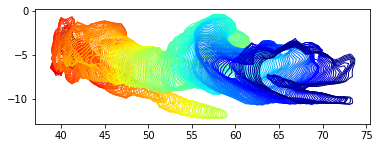

In [5]:
gdf.plot(column='time', facecolor='none', cmap='jet') #, alpha=1) #, legend=True)

/var/folders/v9/8pr92c8s0m14426rc7jfm2c80000gn/T/ipykernel_43368/796279730.py:11: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf.centroid.to_crs(gdf.crs).plot(ax=ax,color='black')
/Users/brianmapes/opt/miniconda3/envs/geopy/lib/python3.10/site-packages/geopandas/plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


Text(0.5, 1.0, 'polygons w/no holes? lasting 7 days, one merger')

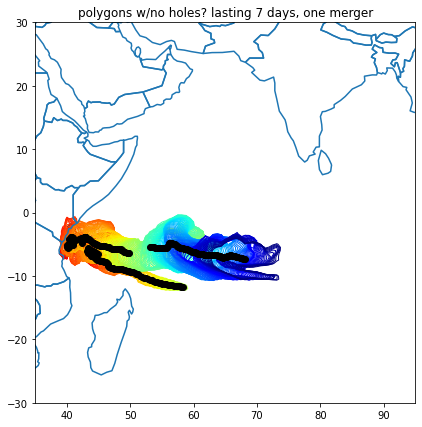

In [6]:
# with map context and centroids 
fig, ax = plt.subplots(figsize=[8,7])
ax.set_aspect('equal')
ax.set_xlim(35, 95)
ax.set_ylim(-30,30)

gdf.plot(ax=ax, column='time', facecolor='none', \
                cmap='jet', alpha=1) #, legend=True)

# OverPlot centroids 
gdf.centroid.to_crs(gdf.crs).plot(ax=ax,color='black')

#gdf.boundary.plot(ax=ax, color='black')
path = gp.datasets.get_path('naturalearth_lowres') # Geography background
mapdf = gp.read_file(path)
mapdf.boundary.plot(ax=ax)
    
ax.set_title('polygons w/no holes? lasting 7 days, one merger')

In [7]:
bounds = gdf.bounds
bounds.minx.min(), bounds.maxx.max(), bounds.miny.min(), bounds.maxy.max(),

(38.781707544120955, 73.71221550687433, -12.27921665736607, -0.398629940257389)

# Open MERRA2 files and combine all the wanted fields 
### (2D hourly collections on goldsmr4) 

In [8]:
d2diag = xr.open_dataset('https://goldsmr4.gesdisc.eosdis.nasa.gov/dods/M2T1NXINT')
d2flux = xr.open_dataset('https://goldsmr4.gesdisc.eosdis.nasa.gov/dods/M2T1NXFLX')
d2slv = xr.open_dataset('https://goldsmr4.gesdisc.eosdis.nasa.gov/dods/M2T1NXSLV')

var_diag = ['dqvdt_phy','dqvdt_dyn','dqvdt_ana','uflxqv','vflxqv','swnettoa']
var_flux = ['eflux','evap','hflux','preccon','precanv','prectot','prevtot','prectotcorr']
var_slv = [ 't2m','ts','t850','t500','q850','q500','slp','tqv','tqi','tql', 'disph' ]

d2super = d2diag[ var_diag ].merge(d2flux[ var_flux ]).merge(d2slv[ var_slv ]).rename({"disph":"distance"})

/Users/brianmapes/opt/miniconda3/envs/geopy/lib/python3.10/site-packages/xarray/coding/times.py:144: SerializationWarning: Ambiguous reference date string: 1-1-1 00:00:0.0. The first value is assumed to be the year hence will be padded with zeros to remove the ambiguity (the padded reference date string is: 0001-1-1 00:00:0.0). To remove this message, remove the ambiguity by padding your reference date strings with zeros.
  warnings.warn(warning_msg, SerializationWarning)


## Select M2 grid area sized to this entire Lake event +/- 5 degrees lat/lon 

In [9]:
d2 = d2super.sel( lat =slice(bounds.miny.min()-5, bounds.maxy.max()+5),
                  lon =slice(bounds.minx.min()-5, bounds.maxx.max()+5), 
                  time=slice(gdf.time.min(),gdf.time.max())             )

In [132]:
# Put a dummy distance field, initially large so min operator will replace it later 

d2.distance.values = d2.distance.values*0 +999.
d2['distance'].attrs['long_name'] = 'distance outside nearest lake (negative for interiors)'
d2['distance'].attrs['units'] = 'degrees'

## Make a Geoseries of grid points from lat,lon coordinates 
### so we can measure all the distances to Lake polygons 

In [15]:
from shapely.geometry import Point

lat2d = d2.lat.values[:,None]   + d2.lon.values*0
lon2d = d2.lat.values[:,None]*0 + d2.lon.values
points = gp.GeoSeries( [Point(x, y) for x, y in zip(lon2d.ravel(),lat2d.ravel()) ] ).set_crs(epsg = "4326", inplace = True)

## Loop over all the Lake geometries (polygons),
# *haven't tested multipolygon with holes in it yet!*,
### updating the minimum distance field at the nearest hour and the hour before 

In [182]:
#    i=205    #for testing --> idx=38, a lovely heart shape
for i in range(gdf.time.size):     # the number of rows in the geoseries (polygons)

# must compute distance to polygon BOUNDARY to get nonzero values inside it 
    dist = points.distance(gdf.geometry[i].boundary).values.reshape(len(d2.lat),len(d2.lon))
    isin = points.within(gdf.geometry[i]).values.reshape(len(d2.lat),len(d2.lon))
    dist *= (-2)*(isin-0.5)  # make SIGNED distance from boundary, positive is exterior 
    
# if less than previous distance in the dataset, replace that previous     
    oldd = d2.sel(time = gdf.time[i],method='nearest').distance
    mindist = np.minimum(dist,oldd)
    
# Here's a tricky thing, assigning values - need to use loc instead of sel
    idx = d2.indexes["time"].get_indexer([gdf.time[i]],method='nearest')[0]
    #print('GDF time: ', gdf.time[i],'index ', idx, 'M2 time: ',d2['time'][idx].values)

# Also these 1-hour averages are 30 minutes offset from tqv, argh. 
    d2["distance"][idx] = mindist
# just manually spray the mindist values to the next earlier time level too 
    try: 
        d2["distance"][idx-1] = mindist
    except: 
        print('end of loop issue')


/var/folders/v9/8pr92c8s0m14426rc7jfm2c80000gn/T/ipykernel_43368/3899632413.py:5: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  dist = points.distance(gdf.geometry[i].boundary).values.reshape(len(d2.lat),len(d2.lon))


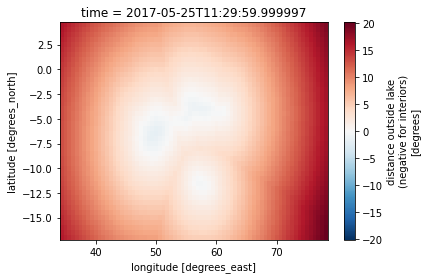

In [233]:
d2['distance'][100].plot() # 100 is a time with multiple fragments 

In [205]:
filename

'2017_05_28_11_lat5p291S.geojson'

In [207]:
d2.to_netcdf('../../Library/CloudStorage/Box-Box/VaporLakes/data/LAKEBYLAKE/'+filename[0:-8]+'.M2_my2Dfields.nc')

/Users/brianmapes/opt/miniconda3/envs/geopy/lib/python3.10/site-packages/xarray/coding/times.py:144: SerializationWarning: Ambiguous reference date string: 1-1-1 00:00:0.0. The first value is assumed to be the year hence will be padded with zeros to remove the ambiguity (the padded reference date string is: 0001-1-1 00:00:0.0). To remove this message, remove the ambiguity by padding your reference date strings with zeros.
  warnings.warn(warning_msg, SerializationWarning)


In [236]:
# read back off disk for faster computation
ddd = xr.open_dataset('../../Library/CloudStorage/Box-Box/VaporLakes/data/LAKEBYLAKE/'+filename[0:-8]+'.M2_my2Dfields.nc')

In [ ]:
composite = ddd.groupby('distance').mean()

In [ ]:
composite